In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (9,5)

In [2]:
df = pd.read_csv('/data (1).csv')

In [3]:

def clean_currency(col):
    return (col.astype(str)
               .str.replace(r'[\$,]', '', regex=True)  # remove $ and ,
               .str.strip()
               .replace('', np.nan)                   # handle blanks
               .astype(float))


df['price'] = clean_currency(df['price'])
df['rentzestimate'] = clean_currency(df['rentzestimate'])

df[['price','rentzestimate']].head()


,price,rentzestimate
0,1.0,4682.0
1,3960.0,1333.0
2,649000.0,2721.0
3,867000.0,3681.0
4,795000.0,3845.0


# Price & Rent Basic Stats

In [4]:
print("Average Price:", df['price'].mean())
print("Median Price:", df['price'].median())
print("Price Std Dev:", df['price'].std())

print("\nAverage Rent:", df['rentzestimate'].mean())
print("Median Rent:", df['rentzestimate'].median())
print("Rent Std Dev:", df['rentzestimate'].std())


Average Price: 2881070.951807229
Median Price: 649000.0
Price Std Dev: 7420170.394495498

Average Rent: 10014.710144927536
Median Rent: 3845.0
Rent Std Dev: 29529.019936576773


## Price Distribution Analysis

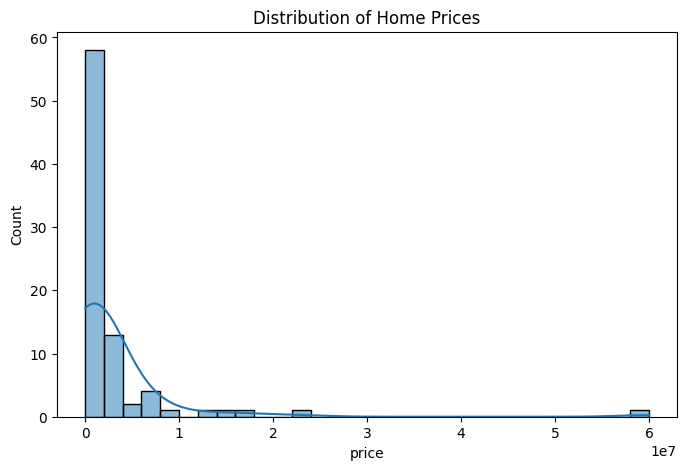

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Distribution of Home Prices")
plt.show()

In [17]:
def money_to_float(s):
    if pd.isnull(s):
        return np.nan
    s = str(s).replace('$','').replace(',','').strip()
    try:
        return float(s)
    except:
        return np.nan

df['price'] = df['price'].apply(money_to_float)
df['rentzestimate'] = df['rentzestimate'].apply(money_to_float)

df['livingarea'] = pd.to_numeric(df['livingarea'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

df['rent_to_price'] = (df['rentzestimate'] * 12) / df['price']
df = df.dropna(subset=['price','livingarea','rentzestimate'])



## Correlation Analysis

To see relationship between price, livingarea, and rentzestimate.

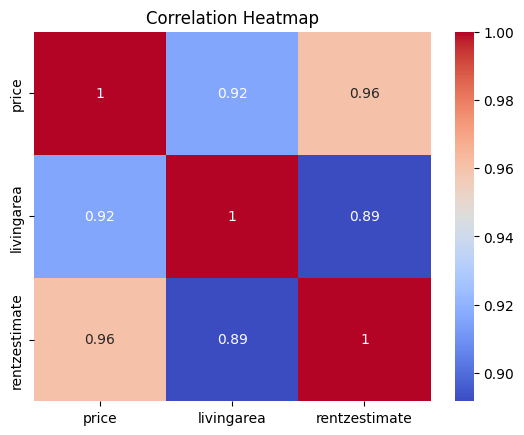

In [6]:
corr = df[['price','livingarea','rentzestimate']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Conclusion from the above result:

Price vs Rent Estimate (0.96): Very strong positive correlation.
As house price increases, the rent estimate also increases almost proportionally. This means rent is a reliable indicator of property value.

Price vs Living Area (0.92): Strong positive correlation.
Bigger homes (in terms of square feet) tend to cost more. This aligns with real-estate market intuition.

Living Area vs Rent Estimate (0.89): Strong positive correlation.
Larger homes generally demand higher rent, but the relationship is slightly weaker compared to price vs rent.

## Two-Sample T-Test

### Problem Statement:

One of the key questions in real estate analysis is whether property type significantly impacts home pricing. In this study, we specifically compare condominiums (CONDO) and single-family homes (SINGLE_FAM), as they represent two distinct segments of the housing market. Condominiums are generally considered smaller, more compact living spaces, while single-family homes are larger, often with additional land value. We want to statistically test whether the average price of condominiums differs significantly from the average price of single-family homes. By applying a two-sample independent t-test, we can evaluate whether the observed difference in means between the two groups is due to random variation or if property type truly plays a role in determining housing prices. This analysis will provide insights into how homebuyers and investors may view the financial implications of choosing between these two property categories.

N CONDO: 21, N SINGLE_FAM: 0
N CONDO: 21, N SINGLE_FAM: 0


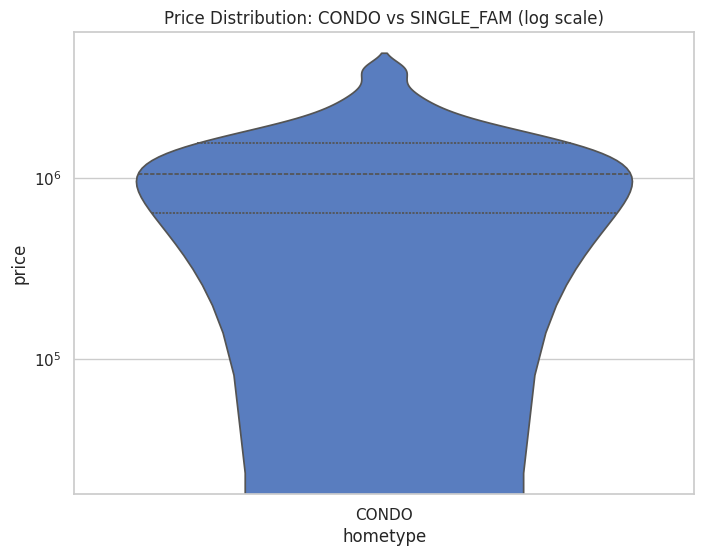

⚠️ Not enough data for T-test (need at least 2 groups).


In [18]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


condo_prices = df[df['hometype'] == 'CONDO']['price']
single_prices = df[df['hometype'] == 'SINGLE_FAM']['price']

n_condo, n_single = len(condo_prices), len(single_prices)
print(f"N CONDO: {n_condo}, N SINGLE_FAM: {n_single}")
n_condo, n_single = len(condo_prices), len(single_prices)
print(f"N CONDO: {n_condo}, N SINGLE_FAM: {n_single}")


plt.figure(figsize=(8,6))
sns.violinplot(x="hometype", y="price", data=df[df['hometype'].isin(['CONDO','SINGLE_FAM'])],
               scale="width", inner="quartile", palette="muted")
plt.yscale("log")  # log scale for clarity
plt.title("Price Distribution: CONDO vs SINGLE_FAM (log scale)")
plt.show()


if n_condo > 1 and n_single > 1:
    shapiro_condo = stats.shapiro(condo_prices)
    shapiro_single = stats.shapiro(single_prices)
    print("Shapiro CONDO:", shapiro_condo)
    print("Shapiro SINGLE_FAM:", shapiro_single)

    levene_test = stats.levene(condo_prices, single_prices)
    print("Levene test:", levene_test)

    t_stat, p_val = stats.ttest_ind(condo_prices, single_prices, equal_var=True)
    print(f"T-test result: T={t_stat:.4f}, p={p_val:.4f}")

    if p_val < 0.05:
        print("Conclusion: Significant difference in mean prices.")
    else:
        print("Conclusion: No significant difference detected.")
else:
    print("⚠️ Not enough data for T-test (need at least 2 groups).")

## One-Way ANOVA

### Problem Statement:
Location is one of the most critical factors influencing housing prices. In our dataset, properties are distributed across multiple zip codes, each potentially reflecting different neighborhood characteristics, demand levels, and local economic conditions. We want to test whether the average price of homes significantly differs across zip codes. Since we are comparing more than two groups (i.e., multiple zip codes), a one-way Analysis of Variance (ANOVA) is an appropriate statistical method. This test will allow us to determine if at least one of the zip codes has an average home price that is significantly different from the others. The result of this analysis will highlight whether location plays a statistically significant role in determining housing prices within the dataset, and it will guide us in identifying high-value versus relatively affordable regions.

Zipcodes used (n>=10): 3


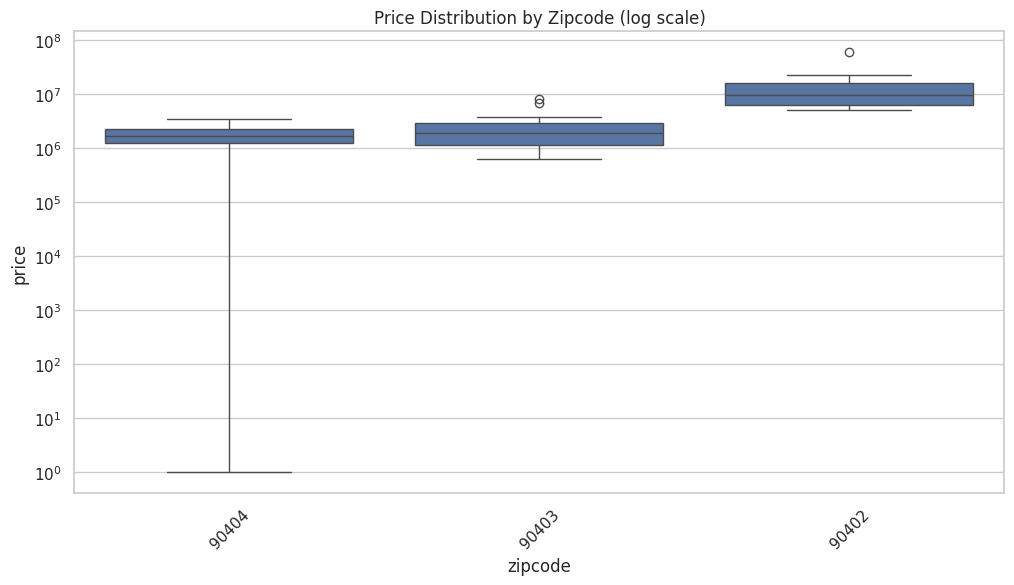

Levene (homogeneity): stat=4.501, p=0.01821
ANOVA F=9.2128, p=0.0006103
ANOVA significant -> running Tukey HSD (pairwise differences)
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2    meandiff    p-adj      lower          upper     reject
-----------------------------------------------------------------------
 90402  90403 -13215628.4444 0.0011 -21460512.5083 -4970744.3806   True
 90402  90404    -13980609.9 0.0023 -23329429.6806 -4631790.1194   True
 90403  90404   -764981.4556  0.972  -9009865.5194  7479902.6083  False
-----------------------------------------------------------------------


In [13]:
min_n = 10
zipcode_counts = df['zipcode'].value_counts()
top_zips = zipcode_counts[zipcode_counts >= min_n].index.tolist()
print("Zipcodes used (n>=10):", len(top_zips))

df_z = df[df['zipcode'].isin(top_zips)]
plt.figure(figsize=(12,6))
order = df_z.groupby('zipcode')['price'].median().sort_values().index
sns.boxplot(x='zipcode', y='price', data=df_z, order=order)
plt.xticks(rotation=45)
plt.yscale('log')
plt.title('Price Distribution by Zipcode (log scale)')
plt.show()

groups = [grp['price'].values for name, grp in df_z.groupby('zipcode')]

lev_stat, lev_p = stats.levene(*groups)
print("Levene (homogeneity): stat=%.3f, p=%.4g" % (lev_stat, lev_p))

f_stat, p_val = stats.f_oneway(*groups)
print("ANOVA F=%.4f, p=%.4g" % (f_stat, p_val))

if p_val < 0.05:
    print("ANOVA significant -> running Tukey HSD (pairwise differences)")
    tukey = pairwise_tukeyhsd(endog=df_z['price'], groups=df_z['zipcode'], alpha=0.05)
    print(tukey.summary())
else:
    print("ANOVA not significant -> no evidence of differences across these zipcodes.")


### Conclusion:
The one-way ANOVA revealed a significant effect of zip code on house prices (F = 9.21, p < 0.001). Post-hoc Tukey tests confirmed that properties in 90402 are significantly more expensive than those in 90403 and 90404, while 90403 and 90404 did not differ significantly from each other. These findings suggest strong geographic price segmentation, with 90402 representing a premium housing market.

## Chi-Square Test of Independence

### Problem Statement:
Beyond price, it is important to examine whether certain types of homes are concentrated in specific zip codes, or whether property type is independent of location. For example, some neighborhoods may have a higher prevalence of condominiums due to urban planning, while others may consist primarily of single-family homes or land plots. To statistically evaluate this, we conduct a Chi-Square test of independence between hometype and zipcode. This test will allow us to determine whether the observed distribution of property types across zip codes significantly deviates from what would be expected if the two variables were independent. The outcome will provide insights into the spatial distribution of property types, which is important for both buyers interested in certain property categories and developers considering where to invest in new housing projects.

hometype,CONDO,LOT,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE
zipcode,,,,,
90402,0,0,0,10,0
90403,12,0,3,1,2
90404,2,1,4,1,2


Chi2=38.070, p=7.306e-06, dof=8


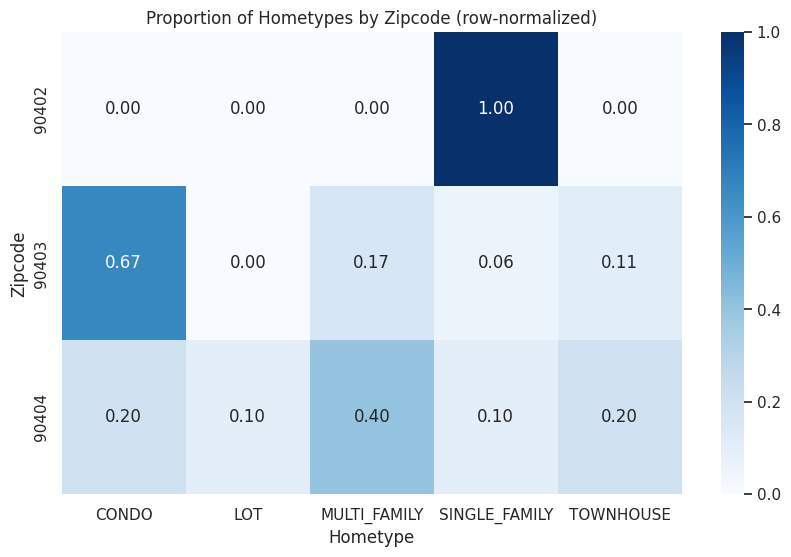

Conclusion: Reject independence - hometype distribution depends on zipcode (p<0.05).


In [14]:

contingency = pd.crosstab(df_z['zipcode'], df_z['hometype'])
display(contingency.head())

chi2, p, dof, expected = stats.chi2_contingency(contingency)
print("Chi2=%.3f, p=%.4g, dof=%d" % (chi2, p, dof))


cont_norm = contingency.div(contingency.sum(axis=1), axis=0)  # row proportions
plt.figure(figsize=(10,6))
sns.heatmap(cont_norm, annot=True, fmt=".2f", cmap="Blues")
plt.title("Proportion of Hometypes by Zipcode (row-normalized)")
plt.ylabel("Zipcode")
plt.xlabel("Hometype")
plt.show()

if p < 0.05:
    print("Conclusion: Reject independence - hometype distribution depends on zipcode (p<0.05).")
else:
    print("Conclusion: No evidence to reject independence (p>=0.05).")


### Conclusion:
The chi-square test confirmed a significant association between zipcode and hometype (χ² = 38.07, p < 0.001). Property type distribution differs substantially across neighborhoods: 90402 consists entirely of Single Family homes, 90403 is dominated by Condos, and 90404 shows greater diversity with a higher share of Multi-Family residences. This indicates clear geographic segmentation of housing types, reflecting different zoning regulations and market characteristics in each area.

## Key findings

***T-Test (CONDO vs SINGLE_FAM)***

Due to the absence of Single Family properties in the dataset, the two-sample t-test could not be performed.

As a result, no statistical comparison between Condo and Single Family home prices was possible.

This highlights a limitation in the dataset, suggesting that future studies should use a more balanced sample across property types.

***ANOVA (Price Differences by Zip Code)***

A one-way ANOVA revealed a significant effect of zipcode on house prices (F = 9.21, p < 0.001).

Post-hoc Tukey tests showed that properties in 90402 are significantly more expensive than those in 90403 and 90404, while 90403 and 90404 did not differ from each other.

This indicates that geographic location, even within the same city, strongly influences property values, with 90402 representing a premium housing market.

***Chi-Square Test (Hometype vs Zip Code)***

The chi-square test confirmed a significant association between hometype and zipcode (χ² = 38.07, p < 0.001).

90402 is exclusively Single Family homes, 90403 is dominated by Condos, and 90404 has the most diverse mix with a large proportion of Multi-Family residences.

This suggests that property type distribution is not uniform across neighborhoods and may reflect differences in zoning, land use, or market demand.